In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os
import sys
from IPython import display


#-- this selects the first GPU
os.environ['CUDA_VISIBLE_DEVICES']="0"

from os import listdir

from pickle import dump
from pickle import load

import uproot3

import matplotlib as mpl

from datetime import datetime
import subprocess


In [2]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import Loss, BinaryCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import keras

from tensorflow.python.client import device_lib

from pickle import dump


#has_gpu = False

has_gpu = True



from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(patience=20,
               verbose=True,
               restore_best_weights=True)

import os

print(tf.config.list_physical_devices())

if has_gpu :
    #os.environ['CUDA_VISIBLE_DEVICES']="0"
    physical_devices = tf.config.list_physical_devices('GPU') 
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


    print("\n\n printing physical devbices from tf.config.list_physical_devices\n\n")
    print(physical_devices)

    devices = device_lib.list_local_devices()

    print("\n\n printing devices from device_lib.list_local_devices\n\n")
    print(devices)


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


 printing physical devbices from tf.config.list_physical_devices


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


 printing devices from device_lib.list_local_devices


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4259651749703932393
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23013163008
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10597734615425758405
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:41:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2023-09-10 16:20:49.574015: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-10 16:20:49.592885: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-10 16:20:49.593125: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-10 16:20:49.595971: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-10 16:20:49.596159: I tensorflow/compiler/xla/stream_executo

In [3]:


training_name = 'training-bce-mse-version2a'

testmode = False
#testmode = True

#run_training = True
run_training = False



if run_training :
    
    try:
        os.mkdir( '%s-training-output' % training_name )
    except:
        print('\n  Dir %s-training-output already exists\n\n' % training_name )
        print('\n\n HALTING EXECUTION \n\n')
        sys.exit()

        

#--- Hyperparameter settings.


    
#-- settings for nominal running
#max_events =   120000
#max_events =   300000
#max_events =   600000
#max_events =  1000000
max_events =  3000000

#max_events = 15000000
#max_events = 1e9


learning_rate_setval = 5e-5
batch_size_setval = 512
max_epochs = 5000
amsgrad_setval = False
patience_setval = 40
hp_lambda = 1.0

if testmode :

#-- settings for quick syntax checking runthrough
    max_events =   600000
    learning_rate_setval = 1e-3
    batch_size_setval = 4096
    max_epochs = 200






input_file_rapgap = '/data/owen/DIS-reco/h1-2023-06-23-v6c/all-h1-rapgap.root'
input_file_django = '/data/owen/DIS-reco/h1-2023-06-23-v6c/all-h1-django.root'


output_dir = '%s-training-output' % training_name

parfile_name = '%s/setup.txt' % output_dir

if run_training :

    parfile = open( parfile_name,'w')

    parfile.write('%s\n' % datetime.now() )
    parfile.write('training_name : %s\n' % training_name )
    parfile.write('hp_lambda : %s\n' % hp_lambda )
    parfile.write('input_file_rapgap : %s\n' % input_file_rapgap )
    parfile.write('input_file_django : %s\n' % input_file_django )
    parfile.write('max_events : %d\n' % max_events )
    parfile.write('learning_rate_setval_reg : %g\n' % learning_rate_setval )
    parfile.write('batch_size_setval : %d\n' % batch_size_setval )
    parfile.write('max_epochs : %d\n' % max_epochs )
    parfile.write('amsgrad_setval : %g\n' % amsgrad_setval )
    parfile.write('patience_setval : %g\n' % patience_setval )


    parfile.close()

print('\n\n--- Training parameters file: %s\n' % parfile_name )
print( subprocess.getoutput('cat %s' % parfile_name ) )
print('\n\n')



--- Training parameters file: training-bce-mse-version2a-training-output/setup.txt

2023-08-14 16:51:18.493576
training_name : training-bce-mse-version2a
hp_lambda : 1.0
input_file_rapgap : /data/owen/DIS-reco/h1-2023-06-23-v6c/all-h1-rapgap.root
input_file_django : /data/owen/DIS-reco/h1-2023-06-23-v6c/all-h1-django.root
max_events : 3000000
learning_rate_setval_reg : 5e-05
batch_size_setval : 512
max_epochs : 5000
amsgrad_setval : 0
patience_setval : 40
use_weights : 0





In [4]:
%%time


ur_file_rapgap = uproot3.open(input_file_rapgap)

print (ur_file_rapgap.keys()) 
ur_tree_rapgap = ur_file_rapgap['Rapgap/minitree']
print(ur_tree_rapgap)
ur_tree_rapgap.show()


#pandas_df   =  ur_tree.pandas.df(['*'], entrystop=max_events,flatten=True)

pandas_df_rapgap   =  ur_tree_rapgap.pandas.df(
    ['has_isr','has_fsr',
     'tower_sum_40','n_towers_40', 
     'eta_pho_closest_to_ebeam','e_pho_closest_to_ebeam', 'phi_pho_closest_to_ebeam',
     'obs_x', 'obs_y', 'obs_Q2',
     'from_tlv_gen_Q2','from_tlv_gen_x','from_tlv_gen_y',
     'obs_e_e','obs_e_pz','obs_e_pt','obs_e_phi',
     'obs_hfs_e','obs_hfs_pz','obs_hfs_pt','obs_hfs_phi',
     'obs_dphi',
     'Empz', 'obs_e_trk_e',
     'beam_e_e', 'wgt',
     'gen_e_e', 'gen_e_pz', 'gen_e_pt', 'gen_e_eta', 'gen_e_phi',
     'obs_e_eta',
     'gen_hfs_e', 'gen_hfs_pz', 'gen_hfs_pt', 'gen_hfs_eta',
     'gen_hfs_etacut_e','gen_hfs_etacut_pz','gen_hfs_etacut_pt','gen_hfs_etacut_eta', 'gen_hfs_etacut_phi',
     'obs_hfs_eta',
    ],
    entrystop=max_events,flatten=True)

print('\n\n Number of entries in pandas_df:  %d ' % pandas_df_rapgap.shape[0] )

[b'Rapgap;1']
<TTree b'minitree' at 0x7f370c27e8c0>
wgt                        (no streamer)              asdtype('>f4')
Empz                       (no streamer)              asdtype('>f4')
from_tlv_gen_Q2            (no streamer)              asdtype('>f4')
from_tlv_gen_x             (no streamer)              asdtype('>f4')
from_tlv_gen_y             (no streamer)              asdtype('>f4')
beam_e_e                   (no streamer)              asdtype('>f4')
beam_p_e                   (no streamer)              asdtype('>f4')
has_isr                    (no streamer)              asdtype('int8')
has_fsr                    (no streamer)              asdtype('int8')
gen_e_e                    (no streamer)              asdtype('>f4')
gen_e_pz                   (no streamer)              asdtype('>f4')
gen_e_pt                   (no streamer)              asdtype('>f4')
gen_e_phi                  (no streamer)              asdtype('>f4')
gen_e_eta                  (no streamer)         

In [5]:
%%time


ur_file_django = uproot3.open(input_file_django)

print (ur_file_django.keys()) 
ur_tree_django = ur_file_django['Django/minitree']
print(ur_tree_django)
ur_tree_django.show()


#pandas_df   =  ur_tree.pandas.df(['*'], entrystop=max_events,flatten=True)

pandas_df_django   =  ur_tree_django.pandas.df(
    ['has_isr','has_fsr',
     'tower_sum_40','n_towers_40', 
     'eta_pho_closest_to_ebeam','e_pho_closest_to_ebeam', 'phi_pho_closest_to_ebeam',
     'obs_x', 'obs_y', 'obs_Q2',
     'from_tlv_gen_Q2','from_tlv_gen_x','from_tlv_gen_y',
     'obs_e_e','obs_e_pz','obs_e_pt','obs_e_phi',
     'obs_hfs_e','obs_hfs_pz','obs_hfs_pt','obs_hfs_phi',
     'obs_dphi',
     'Empz', 'obs_e_trk_e',
     'beam_e_e', 'wgt',
     'gen_e_e', 'gen_e_pz', 'gen_e_pt', 'gen_e_eta', 'gen_e_phi',
     'obs_e_eta',
     'gen_hfs_e', 'gen_hfs_pz', 'gen_hfs_pt', 'gen_hfs_eta',
     'gen_hfs_etacut_e','gen_hfs_etacut_pz','gen_hfs_etacut_pt','gen_hfs_etacut_eta', 'gen_hfs_etacut_phi',
     'obs_hfs_eta',
    ],
    entrystop=max_events,flatten=True)

print('\n\n Number of entries in pandas_df:  %d ' % pandas_df_django.shape[0] )

[b'Django;1']
<TTree b'minitree' at 0x7f3460169060>
wgt                        (no streamer)              asdtype('>f4')
Empz                       (no streamer)              asdtype('>f4')
from_tlv_gen_Q2            (no streamer)              asdtype('>f4')
from_tlv_gen_x             (no streamer)              asdtype('>f4')
from_tlv_gen_y             (no streamer)              asdtype('>f4')
beam_e_e                   (no streamer)              asdtype('>f4')
beam_p_e                   (no streamer)              asdtype('>f4')
has_isr                    (no streamer)              asdtype('int8')
has_fsr                    (no streamer)              asdtype('int8')
gen_e_e                    (no streamer)              asdtype('>f4')
gen_e_pz                   (no streamer)              asdtype('>f4')
gen_e_pt                   (no streamer)              asdtype('>f4')
gen_e_phi                  (no streamer)              asdtype('>f4')
gen_e_eta                  (no streamer)         

In [6]:
pandas_df_rapgap.eval( 'obs_hfs_Empz = obs_hfs_e - obs_hfs_pz', inplace=True )
pandas_df_rapgap.eval( 'obs_e_Empz = obs_e_e - obs_e_pz', inplace=True )

pandas_df_rapgap.eval( 'obs_event_Empz = obs_hfs_Empz + obs_e_Empz', inplace=True )

pandas_df_rapgap.eval( 'rot_pt1 = 0.70710678 * obs_hfs_pt - 0.70710678 * obs_e_pt', inplace=True )
pandas_df_rapgap.eval( 'rot_pt2 = 0.70710678 * obs_hfs_pt + 0.70710678 * obs_e_pt', inplace=True )

pandas_df_rapgap.eval( 'rot_Empz1 = 0.70710678 * obs_hfs_Empz - 0.70710678 * obs_e_Empz', inplace=True )
pandas_df_rapgap.eval( 'rot_Empz2 = 0.70710678 * obs_hfs_Empz + 0.70710678 * obs_e_Empz', inplace=True )

pandas_df_rapgap.eval( 'gen_log_x = log(from_tlv_gen_x)', inplace=True )
pandas_df_rapgap.eval( 'gen_log_y = log(from_tlv_gen_y)', inplace=True )
pandas_df_rapgap.eval( 'gen_log_Q2 = log(from_tlv_gen_Q2)', inplace=True )

pandas_df_rapgap.eval( 'e_ecal_over_trk_ratio = tower_sum_40/obs_e_trk_e', inplace=True )
pandas_df_rapgap.eval( 'e_ecal_over_trk_ratio = (e_ecal_over_trk_ratio<4)*e_ecal_over_trk_ratio + (e_ecal_over_trk_ratio>4)*4', inplace=True )

pandas_df_rapgap.eval( 'dphi_pho_closest_to_ebeam = obs_e_phi - phi_pho_closest_to_ebeam', inplace=True )
pandas_df_rapgap.eval( 'dphi_pho_closest_to_ebeam = (abs(dphi_pho_closest_to_ebeam)<3.14159265)*(dphi_pho_closest_to_ebeam)+(dphi_pho_closest_to_ebeam>3.14159265)*(dphi_pho_closest_to_ebeam-2*3.14159265) + (dphi_pho_closest_to_ebeam<-3.14159265)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df_rapgap.eval( 'dphi_pho_closest_to_ebeam = (dphi_pho_closest_to_ebeam>0)*dphi_pho_closest_to_ebeam + (dphi_pho_closest_to_ebeam<0)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df_rapgap.eval( 'dphi_pho_closest_to_ebeam = (phi_pho_closest_to_ebeam!=0)*(dphi_pho_closest_to_ebeam)+(phi_pho_closest_to_ebeam==0)*(-1)', inplace=True )

pandas_df_rapgap.eval( 'e_pho_closest_to_ebeam = (e_pho_closest_to_ebeam<30)*e_pho_closest_to_ebeam + (e_pho_closest_to_ebeam>30)*30', inplace=True )

pandas_df_rapgap.eval( 'n_towers_40 = (n_towers_40<7)*n_towers_40 + (n_towers_40>=7)*7', inplace=True  )

pandas_df_rapgap.eval( 'has_norad = (has_isr==0) and (has_fsr==0)', inplace=True )

In [7]:
pandas_df_django.eval( 'obs_hfs_Empz = obs_hfs_e - obs_hfs_pz', inplace=True )
pandas_df_django.eval( 'obs_e_Empz = obs_e_e - obs_e_pz', inplace=True )

pandas_df_django.eval( 'obs_event_Empz = obs_hfs_Empz + obs_e_Empz', inplace=True )

pandas_df_django.eval( 'rot_pt1 = 0.70710678 * obs_hfs_pt - 0.70710678 * obs_e_pt', inplace=True )
pandas_df_django.eval( 'rot_pt2 = 0.70710678 * obs_hfs_pt + 0.70710678 * obs_e_pt', inplace=True )

pandas_df_django.eval( 'rot_Empz1 = 0.70710678 * obs_hfs_Empz - 0.70710678 * obs_e_Empz', inplace=True )
pandas_df_django.eval( 'rot_Empz2 = 0.70710678 * obs_hfs_Empz + 0.70710678 * obs_e_Empz', inplace=True )

pandas_df_django.eval( 'gen_log_x = log(from_tlv_gen_x)', inplace=True )
pandas_df_django.eval( 'gen_log_y = log(from_tlv_gen_y)', inplace=True )
pandas_df_django.eval( 'gen_log_Q2 = log(from_tlv_gen_Q2)', inplace=True )

pandas_df_django.eval( 'e_ecal_over_trk_ratio = tower_sum_40/obs_e_trk_e', inplace=True )
pandas_df_django.eval( 'e_ecal_over_trk_ratio = (e_ecal_over_trk_ratio<4)*e_ecal_over_trk_ratio + (e_ecal_over_trk_ratio>4)*4', inplace=True )

pandas_df_django.eval( 'dphi_pho_closest_to_ebeam = obs_e_phi - phi_pho_closest_to_ebeam', inplace=True )
pandas_df_django.eval( 'dphi_pho_closest_to_ebeam = (abs(dphi_pho_closest_to_ebeam)<3.14159265)*(dphi_pho_closest_to_ebeam)+(dphi_pho_closest_to_ebeam>3.14159265)*(dphi_pho_closest_to_ebeam-2*3.14159265) + (dphi_pho_closest_to_ebeam<-3.14159265)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df_django.eval( 'dphi_pho_closest_to_ebeam = (dphi_pho_closest_to_ebeam>0)*dphi_pho_closest_to_ebeam + (dphi_pho_closest_to_ebeam<0)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df_django.eval( 'dphi_pho_closest_to_ebeam = (phi_pho_closest_to_ebeam!=0)*(dphi_pho_closest_to_ebeam)+(phi_pho_closest_to_ebeam==0)*(-1)', inplace=True )

pandas_df_django.eval( 'e_pho_closest_to_ebeam = (e_pho_closest_to_ebeam<30)*e_pho_closest_to_ebeam + (e_pho_closest_to_ebeam>30)*30', inplace=True )

pandas_df_django.eval( 'n_towers_40 = (n_towers_40<7)*n_towers_40 + (n_towers_40>=7)*7', inplace=True  )

pandas_df_django.eval( 'has_norad = (has_isr==0) and (has_fsr==0)', inplace=True )

In [8]:


pandas_df_rapgap.eval( 'obs_ptbal = 1. - obs_e_pt / obs_hfs_pt', inplace=True )
pandas_df_rapgap.eval( 'obs_pzbal = 1. - (obs_hfs_Empz + obs_e_Empz)/2./beam_e_e', inplace=True )



In [9]:


pandas_df_django.eval( 'obs_ptbal = 1. - obs_e_pt / obs_hfs_pt', inplace=True )
pandas_df_django.eval( 'obs_pzbal = 1. - (obs_hfs_Empz + obs_e_Empz)/2./beam_e_e', inplace=True )



In [10]:
pandas_df_rapgap.eval( 'gen_dphi_etacut = (gen_e_phi - gen_hfs_etacut_phi) + ((gen_e_phi - gen_hfs_etacut_phi)<0)*2*3.14159 - ((gen_e_phi - gen_hfs_etacut_phi)>2*3.14159)*2*3.14159', inplace=True )

In [11]:
pandas_df_django.eval( 'gen_dphi_etacut = (gen_e_phi - gen_hfs_etacut_phi) + ((gen_e_phi - gen_hfs_etacut_phi)<0)*2*3.14159 - ((gen_e_phi - gen_hfs_etacut_phi)>2*3.14159)*2*3.14159', inplace=True )

## Apply any event selection here.

In [12]:
pandas_df_rapgap = pandas_df_rapgap.query('Empz > 0')

pandas_df_rapgap = pandas_df_rapgap.query('obs_event_Empz > 46 and obs_event_Empz < 62')

pandas_df_rapgap = pandas_df_rapgap.query('obs_hfs_pt > 0')

pandas_df_rapgap = pandas_df_rapgap.query('from_tlv_gen_Q2 > 200')

pandas_df_rapgap = pandas_df_rapgap.query('e_ecal_over_trk_ratio > 0')

#-- 2023-06-23 : remove small fraction of events that have gen_hfs_etacut_e = 0

pandas_df_rapgap = pandas_df_rapgap.query('gen_hfs_etacut_e > 0')

print('\n\n Number of entries in pandas_df_rapgap:  %d ' % pandas_df_rapgap.shape[0] )



 Number of entries in pandas_df_rapgap:  613773 


In [13]:
pandas_df_django = pandas_df_django.query('Empz > 0')

pandas_df_django = pandas_df_django.query('obs_event_Empz > 46 and obs_event_Empz < 62')

pandas_df_django = pandas_df_django.query('obs_hfs_pt > 0')

pandas_df_django = pandas_df_django.query('from_tlv_gen_Q2 > 200')

pandas_df_django = pandas_df_django.query('e_ecal_over_trk_ratio > 0')

#-- 2023-06-23 : remove small fraction of events that have gen_hfs_etacut_e = 0

pandas_df_django = pandas_df_django.query('gen_hfs_etacut_e > 0')

print('\n\n Number of entries in pandas_df_django:  %d ' % pandas_df_django.shape[0] )



 Number of entries in pandas_df_django:  564057 


In [14]:
pandas_df_rapgap

,has_isr,has_fsr,tower_sum_40,n_towers_40,eta_pho_closest_to_ebeam,e_pho_closest_to_ebeam,phi_pho_closest_to_ebeam,obs_x[0],obs_x[1],obs_x[2],...,rot_Empz2,gen_log_x,gen_log_y,gen_log_Q2,e_ecal_over_trk_ratio,dphi_pho_closest_to_ebeam,has_norad,obs_ptbal,obs_pzbal,gen_dphi_etacut
entry,,,,,,,,,,,,,,,,,,,,,
23,0,0,24.247692,1,-0.182699,0.144760,2.422777,0.015283,0.019567,0.009369,...,43.001450,-4.329937,-1.276337,5.922210,1.071315,0.428013,True,0.060719,-0.101689,3.202085
36,0,1,13.348120,1,-1.709016,0.566964,-0.436204,0.003809,0.002255,0.004362,...,37.739708,-5.503805,-0.571310,5.453369,0.988650,2.755722,False,-0.035760,0.033116,3.166307
45,0,0,25.104801,1,-0.021559,1.420366,2.370969,0.013934,0.019074,0.008570,...,42.132053,-4.499992,-1.604122,5.424370,2.409008,3.302941,True,0.168212,-0.079415,3.160574
47,0,1,20.143602,1,0.018809,0.729400,-1.816074,0.007061,0.004471,0.008294,...,37.633305,-4.799874,-1.136600,5.592010,1.761387,2.691795,False,0.091957,0.035842,3.144557
56,1,0,32.968731,1,0.195189,0.114277,0.189013,0.092370,0.113946,0.127623,...,38.093636,-1.782004,-2.935359,6.801494,0.950580,3.264253,False,0.052082,0.024048,3.155321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999978,0,0,29.941027,1,1.322684,0.225233,-1.767398,0.044368,0.048523,0.059957,...,37.481941,-2.872268,-1.924640,6.731575,2.845239,2.932869,True,0.094121,0.039720,3.140613
2999984,0,0,25.384007,1,0.758430,0.135375,-1.940322,0.013417,0.007338,0.019171,...,37.511471,-3.935594,-2.249312,5.343578,1.021598,0.233744,True,0.047993,0.038963,3.158126
2999988,0,1,24.123011,1,-0.261212,3.840036,-0.663984,0.012221,0.015808,0.009090,...,41.129143,-4.652722,-1.352999,5.522763,4.000000,3.402529,False,-0.057863,-0.053721,3.155354


In [15]:
pandas_df_django

,has_isr,has_fsr,tower_sum_40,n_towers_40,eta_pho_closest_to_ebeam,e_pho_closest_to_ebeam,phi_pho_closest_to_ebeam,obs_x[0],obs_x[1],obs_x[2],...,rot_Empz2,gen_log_x,gen_log_y,gen_log_Q2,e_ecal_over_trk_ratio,dphi_pho_closest_to_ebeam,has_norad,obs_ptbal,obs_pzbal,gen_dphi_etacut
entry,,,,,,,,,,,,,,,,,,,,,
20,0,0,17.255196,1,-1.066193,0.240274,1.518299,0.004745,0.002059,0.005654,...,37.362167,-5.230584,-0.867193,5.430706,0.931784,2.221198,True,0.123451,0.042788,3.177054
22,0,0,29.893789,1,0.895007,0.601942,2.087080,0.052515,0.058272,0.067616,...,38.152119,-2.721840,-2.399088,6.407556,0.984936,2.996598,True,-0.094159,0.022550,3.175841
27,0,0,23.783131,1,-0.131410,0.446848,-1.933851,0.011714,0.016146,0.008042,...,41.864983,-4.471905,-1.468582,5.587996,1.080399,2.321987,True,0.317030,-0.072573,3.076885
33,1,0,24.646885,1,1.005825,0.120665,0.242550,0.015225,0.018389,0.011058,...,41.343658,-4.208622,-1.516757,5.799310,1.080347,1.063548,False,0.240941,-0.059217,3.212621
38,0,0,12.380091,1,-2.888133,1.764309,-0.540577,0.003480,0.003441,0.003494,...,38.996613,-5.732018,-0.448362,5.348104,0.986371,3.510371,True,-0.131654,0.000914,3.076051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999970,1,0,21.685556,1,-2.256334,8.394147,2.447153,0.008636,0.009761,0.007985,...,39.685410,-1.904118,-3.819149,5.458082,1.049069,6.162529,False,-0.692709,-0.016733,3.082457
2999975,0,0,23.934727,1,0.277469,0.352661,1.015150,0.010451,0.008657,0.011655,...,38.363922,-4.495461,-1.628446,5.404577,0.980746,3.396799,True,-0.041800,0.017124,3.163761
2999981,0,1,53.966328,1,2.628084,0.729838,2.014559,0.310944,0.592958,0.658529,...,37.037674,-0.519238,-2.862104,8.147141,1.068173,2.003499,False,-0.084287,0.051102,3.139594


## Set up machine learning stuff

In [16]:
X_gen_r = np.c_[
    pandas_df_rapgap['gen_e_e'].to_numpy(),
    pandas_df_rapgap['gen_e_pz'].to_numpy(),
    pandas_df_rapgap['gen_e_pt'].to_numpy(),
    pandas_df_rapgap['gen_e_eta'].to_numpy(),
    pandas_df_rapgap['gen_hfs_etacut_e'].to_numpy(),
    pandas_df_rapgap['gen_hfs_etacut_pz'].to_numpy(),
    pandas_df_rapgap['gen_hfs_etacut_pt'].to_numpy(),
    pandas_df_rapgap['gen_hfs_etacut_eta'].to_numpy(),
    pandas_df_rapgap['gen_dphi_etacut'].to_numpy(),
]

X_obs_r = np.c_[
    pandas_df_rapgap['obs_e_e'].to_numpy(),
    pandas_df_rapgap['obs_e_pz'].to_numpy(),
    pandas_df_rapgap['obs_e_pt'].to_numpy(),
    pandas_df_rapgap['obs_e_eta'].to_numpy(),
    pandas_df_rapgap['obs_hfs_e'].to_numpy(),
    pandas_df_rapgap['obs_hfs_pz'].to_numpy(),
    pandas_df_rapgap['obs_hfs_pt'].to_numpy(),
    pandas_df_rapgap['obs_hfs_eta'].to_numpy(),
    pandas_df_rapgap['obs_dphi'].to_numpy(),
]

X_r = np.c_[
    pandas_df_rapgap['gen_e_e'].to_numpy(),
    pandas_df_rapgap['gen_e_pz'].to_numpy(),
    pandas_df_rapgap['gen_e_pt'].to_numpy(),
    pandas_df_rapgap['gen_e_eta'].to_numpy(),
    pandas_df_rapgap['gen_hfs_etacut_e'].to_numpy(),
    pandas_df_rapgap['gen_hfs_etacut_pz'].to_numpy(),
    pandas_df_rapgap['gen_hfs_etacut_pt'].to_numpy(),
    pandas_df_rapgap['gen_hfs_etacut_eta'].to_numpy(),
    pandas_df_rapgap['gen_dphi_etacut'].to_numpy(),
    pandas_df_rapgap['obs_e_e'].to_numpy(),
    pandas_df_rapgap['obs_e_pz'].to_numpy(),
    pandas_df_rapgap['obs_e_pt'].to_numpy(),
    pandas_df_rapgap['obs_e_eta'].to_numpy(),
    pandas_df_rapgap['obs_hfs_e'].to_numpy(),
    pandas_df_rapgap['obs_hfs_pz'].to_numpy(),
    pandas_df_rapgap['obs_hfs_pt'].to_numpy(),
    pandas_df_rapgap['obs_hfs_eta'].to_numpy(),
    pandas_df_rapgap['obs_dphi'].to_numpy(),
]


w_r = np.c_[
    pandas_df_rapgap['wgt'].to_numpy(),
]

Y_r = np.c_[
    np.ones(len(pandas_df_rapgap))
]

In [17]:
print(" shapes:  X_gen_r = %s , X_obs_r = %s , X_r = %s,   w_r = %s , Y_r = %s" % ( str(np.shape(X_gen_r)), str(np.shape(X_obs_r)), str(np.shape(X_r)),str(np.shape(w_r)), str(np.shape(Y_r)) ) )


 shapes:  X_gen_r = (613773, 9) , X_obs_r = (613773, 9) , X_r = (613773, 18),   w_r = (613773, 1) , Y_r = (613773, 1)


In [18]:
X_gen_d = np.c_[
    pandas_df_django['gen_e_e'].to_numpy(),
    pandas_df_django['gen_e_pz'].to_numpy(),
    pandas_df_django['gen_e_pt'].to_numpy(),
    pandas_df_django['gen_e_eta'].to_numpy(),
    pandas_df_django['gen_hfs_etacut_e'].to_numpy(),
    pandas_df_django['gen_hfs_etacut_pz'].to_numpy(),
    pandas_df_django['gen_hfs_etacut_pt'].to_numpy(),
    pandas_df_django['gen_hfs_etacut_eta'].to_numpy(),
    pandas_df_django['gen_dphi_etacut'].to_numpy(),
]

X_obs_d = np.c_[
    pandas_df_django['obs_e_e'].to_numpy(),
    pandas_df_django['obs_e_pz'].to_numpy(),
    pandas_df_django['obs_e_pt'].to_numpy(),
    pandas_df_django['obs_e_eta'].to_numpy(),
    pandas_df_django['obs_hfs_e'].to_numpy(),
    pandas_df_django['obs_hfs_pz'].to_numpy(),
    pandas_df_django['obs_hfs_pt'].to_numpy(),
    pandas_df_django['obs_hfs_eta'].to_numpy(),
    pandas_df_django['obs_dphi'].to_numpy(),
]

X_d = np.c_[
    pandas_df_django['gen_e_e'].to_numpy(),
    pandas_df_django['gen_e_pz'].to_numpy(),
    pandas_df_django['gen_e_pt'].to_numpy(),
    pandas_df_django['gen_e_eta'].to_numpy(),
    pandas_df_django['gen_hfs_etacut_e'].to_numpy(),
    pandas_df_django['gen_hfs_etacut_pz'].to_numpy(),
    pandas_df_django['gen_hfs_etacut_pt'].to_numpy(),
    pandas_df_django['gen_hfs_etacut_eta'].to_numpy(),
    pandas_df_django['gen_dphi_etacut'].to_numpy(),
    pandas_df_django['obs_e_e'].to_numpy(),
    pandas_df_django['obs_e_pz'].to_numpy(),
    pandas_df_django['obs_e_pt'].to_numpy(),
    pandas_df_django['obs_e_eta'].to_numpy(),
    pandas_df_django['obs_hfs_e'].to_numpy(),
    pandas_df_django['obs_hfs_pz'].to_numpy(),
    pandas_df_django['obs_hfs_pt'].to_numpy(),
    pandas_df_django['obs_hfs_eta'].to_numpy(),
    pandas_df_django['obs_dphi'].to_numpy(),
]


w_d = np.c_[
    pandas_df_django['wgt'].to_numpy(),
]

Y_d = np.c_[
    np.zeros(len(pandas_df_django))
]


In [19]:
print(" shapes:  X_gen_d = %s , X_obs_d = %s , X_d = %s,  w_d = %s , Y_d = %s" % ( str(np.shape(X_gen_d)), str(np.shape(X_obs_d)), str(np.shape(X_d)), str(np.shape(w_d)), str(np.shape(Y_d)) ) )

 shapes:  X_gen_d = (564057, 9) , X_obs_d = (564057, 9) , X_d = (564057, 18),  w_d = (564057, 1) , Y_d = (564057, 1)


In [20]:
X_gen = np.concatenate( [X_gen_r, X_gen_d] )
X_obs = np.concatenate( [X_obs_r, X_obs_d] )

X = np.concatenate( [X_r, X_d] )

w = np.concatenate( [w_r, w_d])

Y = np.concatenate( [Y_r, Y_d])

In [21]:
print(" shapes:  X_gen = %s , X_obs = %s ,  X = %s,  w = %s , Y = %s" % ( str(np.shape(X_gen)),  str(np.shape(X_obs)),   str(np.shape(X)),  str(np.shape(w)), str(np.shape(Y)) ) )

 shapes:  X_gen = (1177830, 9) , X_obs = (1177830, 9) ,  X = (1177830, 18),  w = (1177830, 1) , Y = (1177830, 1)


In [22]:

scaler_file = "%s/input-scaler.pkl" % output_dir

if run_training :
    print("Creating new scaler.")
    scalerX = StandardScaler()
    scalerX.fit(X)
else :
    print("Reading scaler from file: %s" % scaler_file )
    scalerX = load( open(scaler_file, 'rb') )
    
Xs = scalerX.transform(X)


if run_training :
    print("Saving scaler to %s" % scaler_file)
    dump( scalerX, open(scaler_file, 'wb'))


Reading scaler from file: training-bce-mse-version2a-training-output/input-scaler.pkl


In [23]:
X_train, X_test, Y_train, Y_test, w_train, w_test = train_test_split( Xs, Y, w, test_size=0.5 )

In [24]:
print("\n shapes:  X_gen_train = %s , X_obs_train = %s" % ( str(np.shape(X_train)), str(np.shape(X_train))))


 shapes:  X_gen_train = (588915, 18) , X_obs_train = (588915, 18)


In [25]:
Xs_d = scalerX.transform( X_d )

Xs_r = scalerX.transform( X_r )


In [26]:
num_sf = 4

sf_val = [0., 1., 20., 100.]

sf_ind = 0

In [27]:
def train_model( mse_sf ) :
    
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    def custom_loss(y_true, y_pred):
        particle_level = y_pred[:,0]
        detector_level = y_pred[:,1]
        loss = bce(y_true,particle_level)  + mse_sf * tf.reduce_mean(tf.square(particle_level - detector_level)) 
        return loss    

    n = 9  # Number of features in input.

    inputs = Input(shape=(2*n,))

    classifier_nn = Sequential()
    classifier_nn.add( Dense( 50, activation="relu", input_dim=n) )
    classifier_nn.add( Dense( 50, activation="relu"))
    classifier_nn.add( Dense( 1, activation="sigmoid"))

    particle_inputs_model2 = classifier_nn( inputs[:,0:n] )
    detector_inputs_model2 = classifier_nn( inputs[:,n:] )

    output2 = tf.stack( [particle_inputs_model2, detector_inputs_model2], axis=1)


    mymodel2 = Model( inputs=[inputs], outputs=[output2])


    opt_adam = tf.keras.optimizers.Adam(learning_rate=learning_rate_setval, amsgrad=False )

    mymodel2.compile( loss=custom_loss, optimizer=opt_adam, metrics=['accuracy'] )


    
    
    training_hist2 = mymodel2.fit( X_train, Y_train, validation_data=(X_test, Y_test), 
            epochs=150, 
            batch_size=batch_size_setval,
           verbose=1)

    plt.plot( training_hist2.history['loss'] )
    plt.plot( training_hist2.history['val_loss'] )
    
    mymodel2.summary()
    
    return mymodel2
    

In [28]:
model_sf_array = []

if run_training :
    for sfi in range(0, num_sf) :
        print("\n\n =============== Training with SF = ", sf_val[sfi], "\n\n" )
        model = train_model( sf_val[sfi])
        model_sf_array.append(model)
        tf.keras.models.save_model( model, "%s/model-sf-%.1f" % (output_dir, sf_val[sfi] ) )
else :
    for sfi in range(0, num_sf) :
        print("\n ======= Loading model for SF = ", sf_val[sfi],"\n\n")
        model = tf.keras.models.load_model( "%s/model-sf-%.1f" % (output_dir, sf_val[sfi] ), compile=False )
        model_sf_array.append(model)
        


 ======= Loading model for SF =  0.0 




2023-09-10 16:20:58.488167: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-10 16:20:58.488416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-10 16:20:58.488587: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-10 16:20:58.488798: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-10 16:20:58.488971: I tensorflow/compiler/xla/stream_executo


 ======= Loading model for SF =  1.0 



 ======= Loading model for SF =  20.0 



 ======= Loading model for SF =  100.0 




In [29]:
model_sf_array

In [30]:
preds = []

for sfi in range(0, num_sf) :
    
    preds.append( model_sf_array[sfi].predict( X_test, batch_size=1024 ) )

155/576 [=======>......................] - ETA: 0s

2023-09-10 16:21:00.211887: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


576/576 [==============================] - 0s 669us/step


In [31]:
pred_mean = []
pred_rms = []
pred_plot_xmin = []
pred_plot_xmax = []

for sfi in range(0, num_sf) :
    
    mean = np.mean( preds[sfi] )
    rms = np.sqrt( np.mean( np.square( preds[sfi] - mean)))
    
    xmin = mean - 4*rms
    xmax = mean + 3*rms
    
    if xmin < 0 :
        xmin = 0
    if xmax > 1 :
        xmax = 1
        
    print("  SF %d :  SF = %7.1f  mean = %7.3f  RMS = %7.3f  x range %7.3f to %7.3f" % (sfi, sf_val[sfi], mean, rms, xmin, xmax))
    
    pred_mean.append(mean)
    pred_rms.append(rms)
    pred_plot_xmin.append(xmin)
    pred_plot_xmax.append(xmax)

  SF 0 :  SF =     0.0  mean =   0.444  RMS =   0.201  x range   0.000 to   1.000
  SF 1 :  SF =     1.0  mean =   0.503  RMS =   0.114  x range   0.045 to   0.847
  SF 2 :  SF =    20.0  mean =   0.521  RMS =   0.029  x range   0.406 to   0.607
  SF 3 :  SF =   100.0  mean =   0.519  RMS =   0.014  x range   0.465 to   0.560


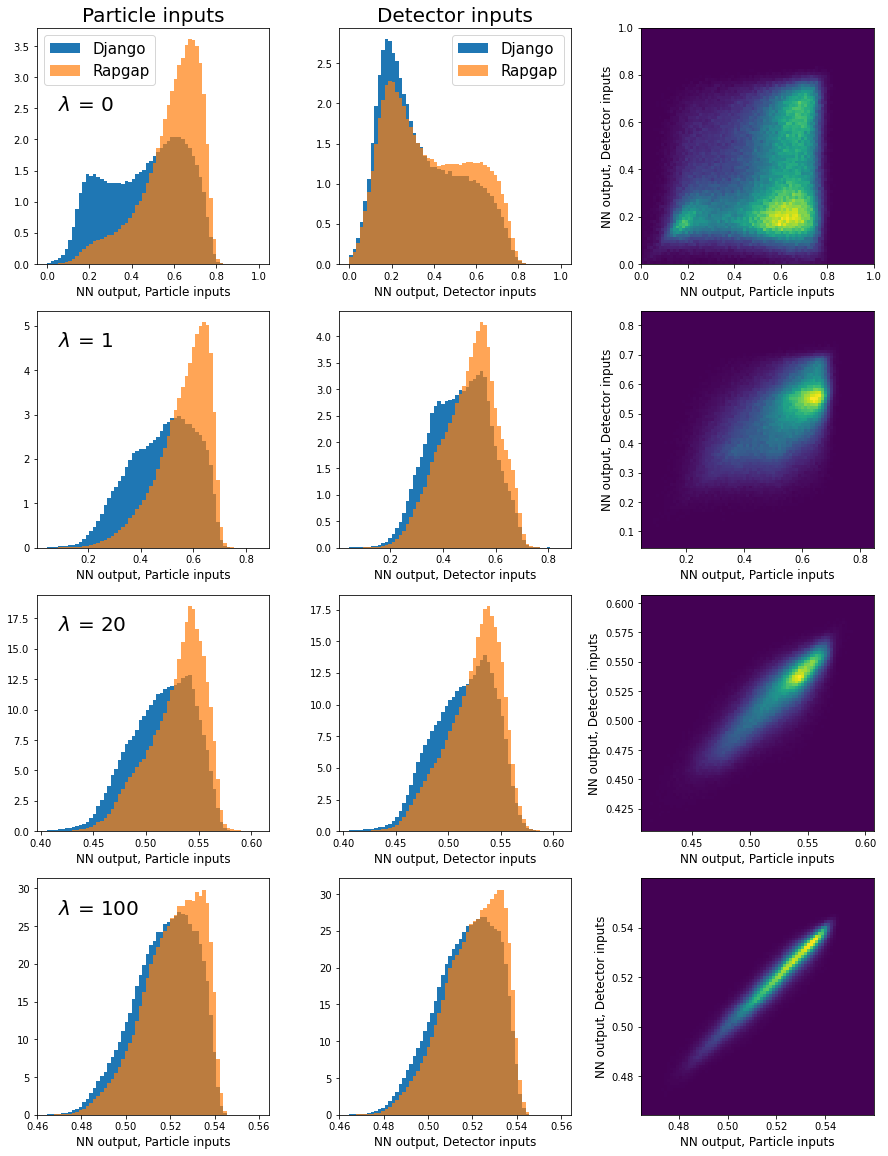

In [32]:
fig,ax = plt.subplots(num_sf,3,figsize=(15,5*num_sf))
#fig.tight_layout()

plt.subplots_adjust( wspace=0.30)

nbins = 60

col_lognorm = False

for sfi in range(0, num_sf) :
    
    xmin = pred_plot_xmin[sfi]
    xmax = pred_plot_xmax[sfi]
    
    ax[sfi][0].hist( preds[sfi][:,0][Y_test==0], density=True, bins=nbins, range=([xmin,xmax]), label='Django' )
    ax[sfi][0].hist( preds[sfi][:,0][Y_test==1], density=True, bins=nbins, range=([xmin,xmax]), label='Rapgap', alpha=0.7 )
    
    ax[sfi][1].hist( preds[sfi][:,1][Y_test==0], density=True, bins=nbins, range=([xmin,xmax]), label='Django' )
    ax[sfi][1].hist( preds[sfi][:,1][Y_test==1], density=True, bins=nbins, range=([xmin,xmax]), label='Rapgap', alpha=0.7 )

    if col_lognorm :
        ax[sfi][2].hist2d( preds[sfi][:,0][Y_test>-1], preds[sfi][:,1][Y_test>-1], bins=80, 
                      range=([xmin,xmax],[xmin,xmax]), norm=mpl.colors.LogNorm())
    
    else :
        ax[sfi][2].hist2d( preds[sfi][:,0][Y_test>-1], preds[sfi][:,1][Y_test>-1], bins=80, 
                      range=([xmin,xmax],[xmin,xmax]) )
        
    
    

ax[0][0].set_title('Particle inputs', fontsize=20)
ax[0][1].set_title('Detector inputs', fontsize=20)


    
ax[0][0].legend(loc='best', fontsize=15)
ax[0][1].legend(loc='best', fontsize=15)

for rowi in range(0,4) :
    xmin = pred_plot_xmin[rowi]
    xmax = pred_plot_xmax[rowi]
    ax[rowi][0].set_xlabel('NN output, Particle inputs', fontsize=12)
    ax[rowi][1].set_xlabel('NN output, Detector inputs', fontsize=12)
    ax[rowi][2].set_xlabel('NN output, Particle inputs', fontsize=12)
    ax[rowi][2].set_ylabel('NN output, Detector inputs', fontsize=12)
    if rowi == 0 :
        ax[rowi][0].text( xmin+0.05*(xmax-xmin), 0.65*ax[rowi][0].get_ylim()[1],'$\lambda$ = %.0f' % sf_val[rowi],fontsize=20)
    else :
        ax[rowi][0].text( xmin+0.05*(xmax-xmin), 0.85*ax[rowi][0].get_ylim()[1],'$\lambda$ = %.0f' % sf_val[rowi],fontsize=20)
        
    
plt.savefig('training-results-varying-lambda.png',bbox_inches='tight')   
plt.savefig('training-results-varying-lambda.pdf',bbox_inches='tight')  

## Make an output root ntuple

In [33]:
preds_all_django = []
preds_all_rapgap = []

for sfi in range(0, num_sf) :
    
    preds_all_django.append( model_sf_array[sfi].predict( Xs_d, batch_size=1024 ) )
    preds_all_rapgap.append( model_sf_array[sfi].predict( Xs_r, batch_size=1024 ) )
    

600/600 [==============================] - 0s 683us/step


In [34]:
pandas_df_django['classifier_output_gen_sf0'] = preds_all_django[0][:,0]
pandas_df_django['classifier_output_gen_sf1'] = preds_all_django[1][:,0]
pandas_df_django['classifier_output_gen_sf2'] = preds_all_django[2][:,0]
pandas_df_django['classifier_output_gen_sf3'] = preds_all_django[3][:,0]

pandas_df_django['classifier_output_obs_sf0'] = preds_all_django[0][:,1]
pandas_df_django['classifier_output_obs_sf1'] = preds_all_django[1][:,1]
pandas_df_django['classifier_output_obs_sf2'] = preds_all_django[2][:,1]
pandas_df_django['classifier_output_obs_sf3'] = preds_all_django[3][:,1]


In [35]:
branch_dict_django = {}
data_dict_django = {}

for k in pandas_df_django.keys() :
    dict_key = k
    dict_key = dict_key.replace('[','').replace(']','')  # in case not in method_names
    print( ' key  %s , dict_key %s' % (k, dict_key) )
    print( ' dtype for %s is ' % k, pandas_df_django[k].dtype)
    branch_dict_django[dict_key] = pandas_df_django[k].dtype
    data_dict_django[dict_key] = pandas_df_django[k].to_numpy()

 key  has_isr , dict_key has_isr
 dtype for has_isr is  int8
 key  has_fsr , dict_key has_fsr
 dtype for has_fsr is  int8
 key  tower_sum_40 , dict_key tower_sum_40
 dtype for tower_sum_40 is  float32
 key  n_towers_40 , dict_key n_towers_40
 dtype for n_towers_40 is  int64
 key  eta_pho_closest_to_ebeam , dict_key eta_pho_closest_to_ebeam
 dtype for eta_pho_closest_to_ebeam is  float32
 key  e_pho_closest_to_ebeam , dict_key e_pho_closest_to_ebeam
 dtype for e_pho_closest_to_ebeam is  float64
 key  phi_pho_closest_to_ebeam , dict_key phi_pho_closest_to_ebeam
 dtype for phi_pho_closest_to_ebeam is  float32
 key  obs_x[0] , dict_key obs_x0
 dtype for obs_x[0] is  float32
 key  obs_x[1] , dict_key obs_x1
 dtype for obs_x[1] is  float32
 key  obs_x[2] , dict_key obs_x2
 dtype for obs_x[2] is  float32
 key  obs_x[3] , dict_key obs_x3
 dtype for obs_x[3] is  float32
 key  obs_x[4] , dict_key obs_x4
 dtype for obs_x[4] is  float32
 key  obs_x[5] , dict_key obs_x5
 dtype for obs_x[5] is  floa

In [36]:
%%time

root_file3 = uproot3.recreate( "output_bce_mse_django.root" )

root_file3['nnout'] = uproot3.newtree( branch_dict_django )

root_file3['nnout'].extend( data_dict_django )

CPU times: user 5.49 s, sys: 112 ms, total: 5.61 s
Wall time: 5.6 s


In [37]:
pandas_df_rapgap['classifier_output_gen_sf0'] = preds_all_rapgap[0][:,0]
pandas_df_rapgap['classifier_output_gen_sf1'] = preds_all_rapgap[1][:,0]
pandas_df_rapgap['classifier_output_gen_sf2'] = preds_all_rapgap[2][:,0]
pandas_df_rapgap['classifier_output_gen_sf3'] = preds_all_rapgap[3][:,0]

pandas_df_rapgap['classifier_output_obs_sf0'] = preds_all_rapgap[0][:,1]
pandas_df_rapgap['classifier_output_obs_sf1'] = preds_all_rapgap[1][:,1]
pandas_df_rapgap['classifier_output_obs_sf2'] = preds_all_rapgap[2][:,1]
pandas_df_rapgap['classifier_output_obs_sf3'] = preds_all_rapgap[3][:,1]


In [38]:
branch_dict_rapgap = {}
data_dict_rapgap = {}

for k in pandas_df_rapgap.keys() :
    dict_key = k
    dict_key = dict_key.replace('[','').replace(']','')  # in case not in method_names
    print( ' key  %s , dict_key %s' % (k, dict_key) )
    print( ' dtype for %s is ' % k, pandas_df_rapgap[k].dtype)
    branch_dict_rapgap[dict_key] = pandas_df_rapgap[k].dtype
    data_dict_rapgap[dict_key] = pandas_df_rapgap[k].to_numpy()

 key  has_isr , dict_key has_isr
 dtype for has_isr is  int8
 key  has_fsr , dict_key has_fsr
 dtype for has_fsr is  int8
 key  tower_sum_40 , dict_key tower_sum_40
 dtype for tower_sum_40 is  float32
 key  n_towers_40 , dict_key n_towers_40
 dtype for n_towers_40 is  int64
 key  eta_pho_closest_to_ebeam , dict_key eta_pho_closest_to_ebeam
 dtype for eta_pho_closest_to_ebeam is  float32
 key  e_pho_closest_to_ebeam , dict_key e_pho_closest_to_ebeam
 dtype for e_pho_closest_to_ebeam is  float64
 key  phi_pho_closest_to_ebeam , dict_key phi_pho_closest_to_ebeam
 dtype for phi_pho_closest_to_ebeam is  float32
 key  obs_x[0] , dict_key obs_x0
 dtype for obs_x[0] is  float32
 key  obs_x[1] , dict_key obs_x1
 dtype for obs_x[1] is  float32
 key  obs_x[2] , dict_key obs_x2
 dtype for obs_x[2] is  float32
 key  obs_x[3] , dict_key obs_x3
 dtype for obs_x[3] is  float32
 key  obs_x[4] , dict_key obs_x4
 dtype for obs_x[4] is  float32
 key  obs_x[5] , dict_key obs_x5
 dtype for obs_x[5] is  floa

In [39]:
%%time

root_file3 = uproot3.recreate( "output_bce_mse_rapgap.root" )

root_file3['nnout'] = uproot3.newtree( branch_dict_rapgap )

root_file3['nnout'].extend( data_dict_rapgap )

CPU times: user 5.96 s, sys: 147 ms, total: 6.1 s
Wall time: 6.14 s


## Some plots of the input features

In [40]:
feature_names = [
    "electron E",
    "electron pz",
    "electron pT",
    "electron $\eta$",
    "HFS E",
    "HFS pz",
    "HFS pT",
    "HFS $\eta$",
    "$\Delta \phi$(e,HFS)",
]

 row =  0  col =  0
 row =  0  col =  1
 row =  0  col =  2
 row =  1  col =  0
 row =  1  col =  1
 row =  1  col =  2
 row =  2  col =  0
 row =  2  col =  1
 row =  2  col =  2


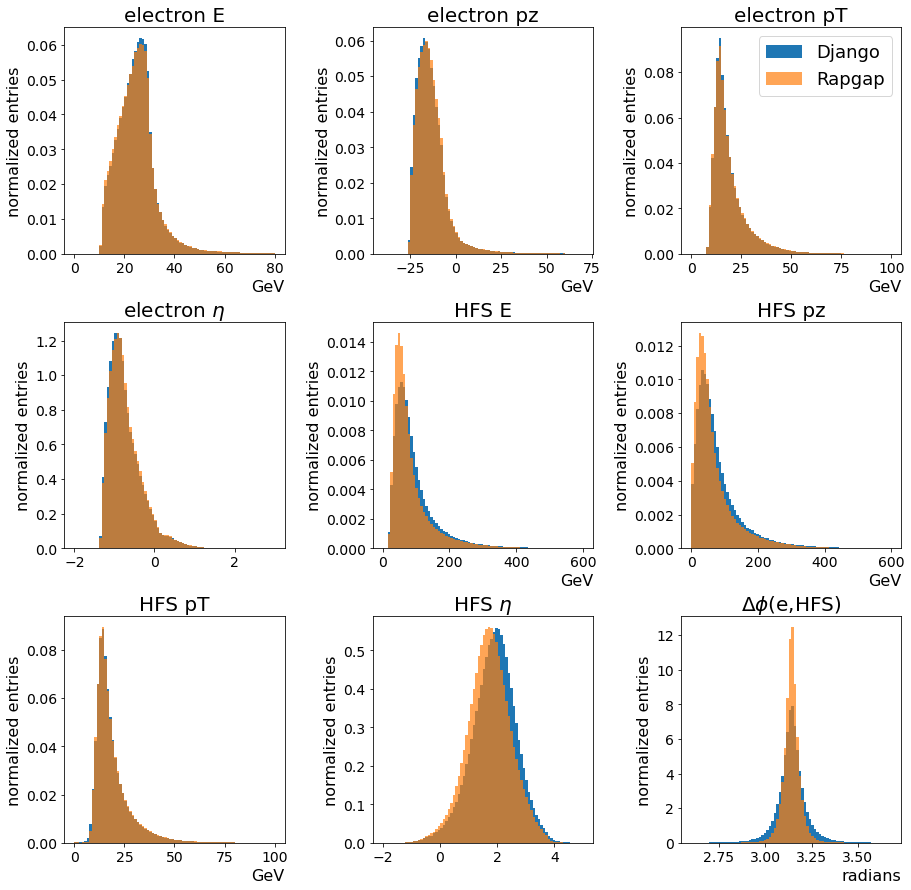

In [41]:
fig,ax = plt.subplots(3,3,figsize=(15,15))



hbins = 80



xmin = [0, -40., 0,    -2., 0., 0.,    0., -2.,  2.6 ]
xmax = [80., 70., 100.,  3., 600., 600.,    100., 5., 3.68 ]


for fi in range(0,9) :
    
    row = int(fi / 3)
    col = fi % 3
    print(" row = ", row, " col = ", col)
    

    ax[row][col].hist( X_gen_d[:,fi], bins=hbins,   range=([xmin[fi],xmax[fi]]), label="Django", density=True )
    ax[row][col].hist( X_gen_r[:,fi], bins=hbins,   range=([xmin[fi],xmax[fi]]), label="Rapgap", density=True, alpha=0.7 )
    
    ax[row][col].set_title(feature_names[fi], fontsize=20 )
    #ax[row][col].legend(loc='best', fontsize=17)
    
    ax[row][col].tick_params( axis='both', labelsize=14 )
        

        
ax[0][2].legend(loc='best', fontsize=18)
    


xlabelfontsize=16

ax[0][0].set_xlabel( 'GeV',  horizontalalignment='right', x=1.0, fontsize=xlabelfontsize )
ax[0][1].set_xlabel( 'GeV',  horizontalalignment='right', x=1.0, fontsize=xlabelfontsize )
ax[0][2].set_xlabel( 'GeV',  horizontalalignment='right', x=1.0, fontsize=xlabelfontsize )


ax[1][1].set_xlabel( 'GeV',  horizontalalignment='right', x=1.0, fontsize=xlabelfontsize )
ax[1][2].set_xlabel( 'GeV',  horizontalalignment='right', x=1.0, fontsize=xlabelfontsize )

ax[2][0].set_xlabel( 'GeV',  horizontalalignment='right', x=1.0, fontsize=xlabelfontsize )
ax[2][2].set_xlabel( 'radians',  horizontalalignment='right', x=1.0, fontsize=xlabelfontsize )



plt.subplots_adjust( hspace=0.3 )
plt.subplots_adjust( wspace=0.4 )

ylabelfontsize=16
for fi in range(0,9) :
    
    row = int(fi / 3)
    col = fi % 3
    ax[row][col].set_ylabel( 'normalized entries', fontsize=ylabelfontsize )



plt.savefig('feature-plots-particle-django-vs-rapgap-comparison.png',bbox_inches='tight')   
plt.savefig('feature-plots-particle-django-vs-rapgap-comparison.pdf',bbox_inches='tight') 

plt.show()


 row =  0  col =  0
 row =  0  col =  1
 row =  0  col =  2
 row =  1  col =  0
 row =  1  col =  1
 row =  1  col =  2
 row =  2  col =  0
 row =  2  col =  1
 row =  2  col =  2


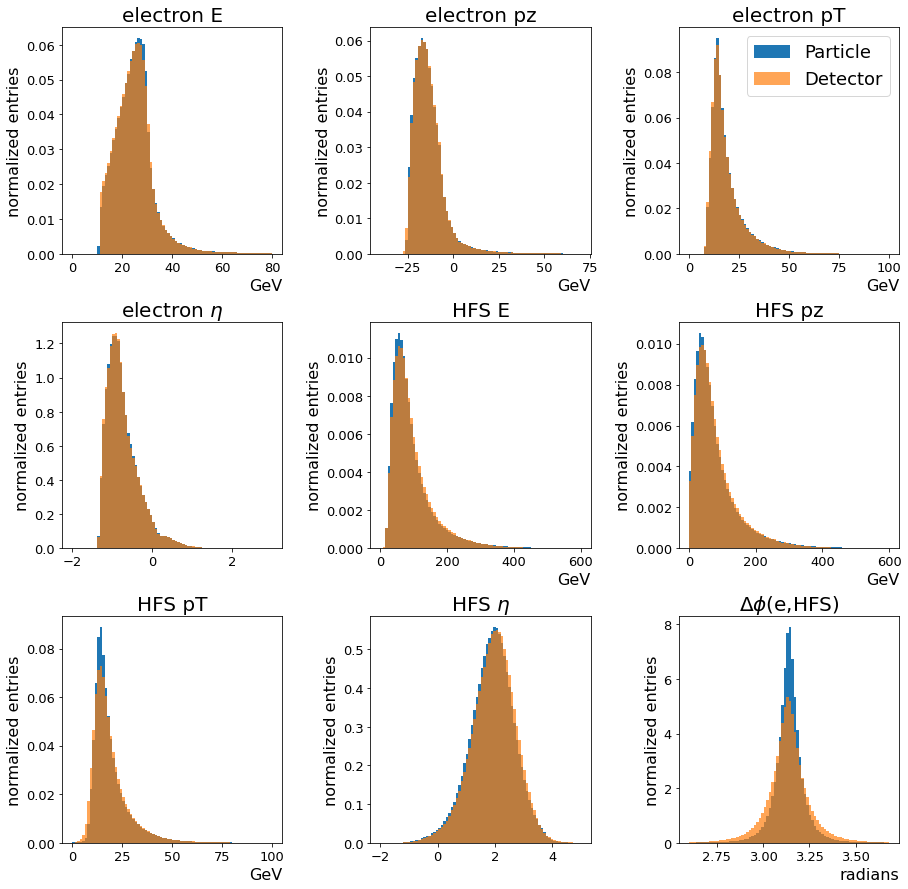

In [42]:
fig,ax = plt.subplots(3,3,figsize=(15,15))

hbins = 80





xmin = [0, -40., 0,    -2., 0., 0.,    0., -2.,  2.6 ]
xmax = [80., 70., 100.,  3., 600., 600.,    100., 5., 3.68 ]


for fi in range(0,9) :
    
    row = int(fi / 3)
    col = fi % 3
    print(" row = ", row, " col = ", col)
    


    ax[row][col].hist( X_gen_d[:,fi], bins=hbins,   range=([xmin[fi],xmax[fi]]), label='Particle', density=True )
    ax[row][col].hist( X_obs_d[:,fi], bins=hbins,   range=([xmin[fi],xmax[fi]]), label='Detector', density=True, alpha=0.7 )
    
    ax[row][col].set_title(feature_names[fi], fontsize=20 )
    #ax[row][col].legend(loc='best', fontsize=17)
    
    ax[row][col].tick_params( axis='both', labelsize=13 ) 


ax[0][2].legend(loc='best', fontsize=18)
    


xlabelfontsize=16

ax[0][0].set_xlabel( 'GeV',  horizontalalignment='right', x=1.0, fontsize=xlabelfontsize )
ax[0][1].set_xlabel( 'GeV',  horizontalalignment='right', x=1.0, fontsize=xlabelfontsize )
ax[0][2].set_xlabel( 'GeV',  horizontalalignment='right', x=1.0, fontsize=xlabelfontsize )


ax[1][1].set_xlabel( 'GeV',  horizontalalignment='right', x=1.0, fontsize=xlabelfontsize )
ax[1][2].set_xlabel( 'GeV',  horizontalalignment='right', x=1.0, fontsize=xlabelfontsize )

ax[2][0].set_xlabel( 'GeV',  horizontalalignment='right', x=1.0, fontsize=xlabelfontsize )
ax[2][2].set_xlabel( 'radians',  horizontalalignment='right', x=1.0, fontsize=xlabelfontsize )


ylabelfontsize=16
for fi in range(0,9) :
    
    row = int(fi / 3)
    col = fi % 3
    ax[row][col].set_ylabel( 'normalized entries', fontsize=ylabelfontsize )



plt.subplots_adjust( hspace=0.3 )
plt.subplots_adjust( wspace=0.4 )

plt.savefig('feature-plots-django-particle-vs-detector-comparison.png',bbox_inches='tight')   
plt.savefig('feature-plots-django-particle-vs-detector-comparison.pdf',bbox_inches='tight') 

plt.show()


 row =  0  col =  0
 row =  0  col =  1
 row =  0  col =  2
 row =  1  col =  0
 row =  1  col =  1
 row =  1  col =  2
 row =  2  col =  0
 row =  2  col =  1
 row =  2  col =  2


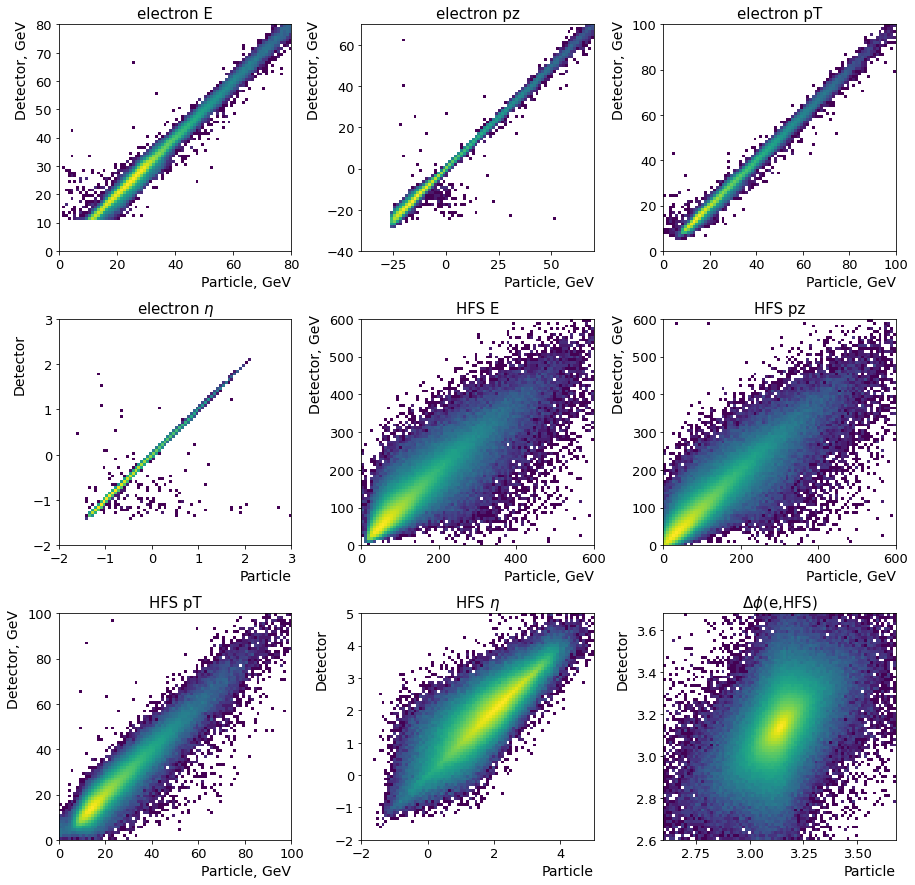

In [43]:
fig,ax = plt.subplots(3,3,figsize=(15,15))

hbins = 80





xmin = [0, -40., 0,    -2., 0., 0.,    0., -2.,  2.6 ]
xmax = [80., 70., 100.,  3., 600., 600.,    100., 5., 3.68 ]


for fi in range(0,9) :
    
    row = int(fi / 3)
    col = fi % 3
    print(" row = ", row, " col = ", col)
    


    ax[row][col].hist2d( X_gen_d[:,fi], X_obs_d[:,fi],
                        bins=hbins,   
                        range=([xmin[fi],xmax[fi]],[xmin[fi],xmax[fi]]),
                        label='', density=True, norm=mpl.colors.LogNorm() )
    
    ax[row][col].set_title(feature_names[fi], fontsize=15 )
    #ax[row][col].legend(loc='best', fontsize=17)
    
    ax[row][col].tick_params( axis='both', labelsize=13 ) 


#ax[0][2].legend(loc='best', fontsize=18)
    


xlabelfontsize=14

ax[0][0].set_xlabel( 'Particle, GeV',  horizontalalignment='right', x=1.0, fontsize=xlabelfontsize )
ax[0][1].set_xlabel( 'Particle, GeV',  horizontalalignment='right', x=1.0, fontsize=xlabelfontsize )
ax[0][2].set_xlabel( 'Particle, GeV',  horizontalalignment='right', x=1.0, fontsize=xlabelfontsize )

ax[1][0].set_xlabel( 'Particle',  horizontalalignment='right', x=1.0, fontsize=xlabelfontsize )
ax[1][1].set_xlabel( 'Particle, GeV',  horizontalalignment='right', x=1.0, fontsize=xlabelfontsize )
ax[1][2].set_xlabel( 'Particle, GeV',  horizontalalignment='right', x=1.0, fontsize=xlabelfontsize )

ax[2][0].set_xlabel( 'Particle, GeV',  horizontalalignment='right', x=1.0, fontsize=xlabelfontsize )
ax[2][1].set_xlabel( 'Particle',  horizontalalignment='right', x=1.0, fontsize=xlabelfontsize )
ax[2][2].set_xlabel( 'Particle',  horizontalalignment='right', x=1.0, fontsize=xlabelfontsize )



ax[0][0].set_ylabel( 'Detector, GeV',  verticalalignment='top', y=0.8, labelpad=20, fontsize=xlabelfontsize )
ax[0][1].set_ylabel( 'Detector, GeV',  verticalalignment='top', y=0.8, labelpad=20, fontsize=xlabelfontsize )
ax[0][2].set_ylabel( 'Detector, GeV',  verticalalignment='top', y=0.8, labelpad=20, fontsize=xlabelfontsize )


ax[1][0].set_ylabel( 'Detector',  verticalalignment='top', y=0.8, labelpad=20, fontsize=xlabelfontsize )
ax[1][1].set_ylabel( 'Detector, GeV',  verticalalignment='top', y=0.8, labelpad=20, fontsize=xlabelfontsize )
ax[1][2].set_ylabel( 'Detector, GeV',  verticalalignment='top', y=0.8, labelpad=20, fontsize=xlabelfontsize )

ax[2][0].set_ylabel( 'Detector, GeV',  verticalalignment='top', y=0.8, labelpad=20, fontsize=xlabelfontsize )
ax[2][1].set_ylabel( 'Detector',  verticalalignment='top', y=0.8, labelpad=20, fontsize=xlabelfontsize )
ax[2][2].set_ylabel( 'Detector',  verticalalignment='top', y=0.8, labelpad=20, fontsize=xlabelfontsize )






plt.subplots_adjust( hspace=0.3 )
plt.subplots_adjust( wspace=0.3 )

plt.savefig('feature-plots-django-particle-vs-detector-2d-comparison.png',bbox_inches='tight')   
plt.savefig('feature-plots-django-particle-vs-detector-2d-comparison.pdf',bbox_inches='tight') 


plt.show()
